# 1 . Import Dependencies

In [ ]:
!pip install tensorflow==2.9.0

In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
import tensorflow_hub as hub
from tensorflow.keras import layers 

In [2]:
tf.__version__

'2.9.0'

# 2 . Import Helper Functions

In [3]:
# Download helper functions script
!wget https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py

--2023-02-27 06:34:01--  https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.110.133, 185.199.108.133, 185.199.109.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.110.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10246 (10K) [text/plain]
Saving to: ‘helper_functions.py.1’

helper_functions.py 100%[===================>]  10.01K  --.-KB/s    in 0s      

2023-02-27 06:34:01 (75.1 MB/s) - ‘helper_functions.py.1’ saved [10246/10246]



In [4]:
# Import calculate_results helper function
from helper_functions import calculate_results,create_tensorboard_callback,plot_loss_curves

# 3 . Load Dataset

In [5]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Setup paths to our data directories
train_dir = '/content/drive/MyDrive/AI_Research/Villains/Train'
test_dir = '/content/drive/MyDrive/AI_Research/Villains/Test'

IMG_SIZE = (224,224)
BATCH_SIZE = 32

train_data_2 = tf.keras.preprocessing.image_dataset_from_directory(directory = train_dir,
                                                                            image_size=IMG_SIZE,
                                                                            label_mode = 'categorical',
                                                                            batch_size=BATCH_SIZE,)
test_data_2 = tf.keras.preprocessing.image_dataset_from_directory(directory = test_dir,
                                                                image_size=IMG_SIZE,
                                                                label_mode='categorical',
                                                                batch_size=BATCH_SIZE)

Found 42 files belonging to 3 classes.
Found 18 files belonging to 3 classes.


In [6]:
# Checking the classes
class_names = train_data_2.class_names
class_names

['Darth Vader', 'Green Goblin', 'Joker']

# 4 . Create Model Callbacks

In [7]:
# Create Early Stopping Callbackss
early_stopping_callback = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', 
                                                          #  min_delta=0.05,
                                                           patience=3, restore_best_weights=True)

# Model 0: FE (Resnet50) -> Functional API -> Augmentation

In [8]:
# Set Checkpoint paths
checkpoint_path = 'Checkpoints_weights/model_0.ckpt'

# Create a ModelCheckpoint callback that saves the model's weights only
checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                         save_weights_only=True,
                                                         save_best_only=False,
                                                         save_freq='epoch', # save ever epoch
                                                         verbose=1)

In [13]:
# Create data augmentation layer
from tensorflow.keras import layers
from tensorflow.keras.layers.experimental import preprocessing
from tensorflow.keras.models import Sequential

# Build data augmentation layer
data_augmentation = Sequential([
    preprocessing.RandomFlip('horizontal'),
    preprocessing.RandomHeight(0.2),
    preprocessing.RandomWidth(0.2),
    preprocessing.RandomZoom(0.2),
    preprocessing.RandomRotation(0.2),
    preprocessing.Rescaling(1./255) # No need since we are using effiecientNet
],name='augmentation')


# Setup the input shape to our model
input_shape = (224,224,3)

# Create a frozen base model
base_model = tf.keras.applications.ResNet50V2(include_top=False)
base_model.trainable = False

# Create the inputs and outputs (including the layers in between)
inputs = layers.Input(shape=input_shape,name='input_layer')
x = data_augmentation(inputs)
# x = base_model(inputs,training=False) 
x = base_model(x,training=False) # pass the augmentated images to the base model but keep it in inference mode
x = layers.GlobalAveragePooling2D(name='global_average_pooling_2D')(x)
outputs = layers.Dense(len(class_names),activation='softmax',name='output_layer')(x)
model_0 = tf.keras.Model(inputs,outputs)

# Compile
model_0.compile(
    loss=tf.keras.losses.CategoricalCrossentropy(),
    optimizer = tf.keras.optimizers.Adam(),
    metrics = ['accuracy']
)

In [14]:
model_0.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 224, 224, 3)]     0         
                                                                 
 augmentation (Sequential)   (None, 224, 224, 3)       0         
                                                                 
 resnet50v2 (Functional)     (None, None, None, 2048)  23564800  
                                                                 
 global_average_pooling_2D (  (None, 2048)             0         
 GlobalAveragePooling2D)                                         
                                                                 
 output_layer (Dense)        (None, 3)                 6147      
                                                                 
Total params: 23,570,947
Trainable params: 6,147
Non-trainable params: 23,564,800
___________________________________________

In [17]:
#Fit the model
initial_epochs = 20
history_0 = model_0.fit(train_data_2,
                        epochs=initial_epochs,
                        validation_data=test_data_2,
                        validation_steps = len(test_data_2),
                        callbacks = [
                                    early_stopping_callback,
                                    #  checkpoint_callback_2, # because it slows down
                                    #  create_tensorboard_callback(dir_name='CV_Question1', experiment_name='model_0')
                                     ]
                        )

Epoch 1/20
2/2 [==============================] - 13s 6s/step - loss: 0.9116 - accuracy: 0.6190 - val_loss: 0.5665 - val_accuracy: 0.7778
Epoch 2/20
2/2 [==============================] - 10s 4s/step - loss: 0.6909 - accuracy: 0.6429 - val_loss: 0.4040 - val_accuracy: 0.8333
Epoch 3/20
2/2 [==============================] - 13s 5s/step - loss: 0.4880 - accuracy: 0.8571 - val_loss: 0.3233 - val_accuracy: 0.9444
Epoch 4/20
2/2 [==============================] - 12s 4s/step - loss: 0.3793 - accuracy: 0.9048 - val_loss: 0.2960 - val_accuracy: 0.8889
Epoch 5/20
2/2 [==============================] - 10s 4s/step - loss: 0.2773 - accuracy: 0.9048 - val_loss: 0.3027 - val_accuracy: 0.8889
Epoch 6/20
2/2 [==============================] - 12s 6s/step - loss: 0.2805 - accuracy: 0.8571 - val_loss: 0.3189 - val_accuracy: 0.8889


## Evaluate

In [18]:
model_0.evaluate(test_data_2)

1/1 [==============================] - 4s 4s/step - loss: 0.3233 - accuracy: 0.9444


[0.3232804536819458, 0.9444444179534912]

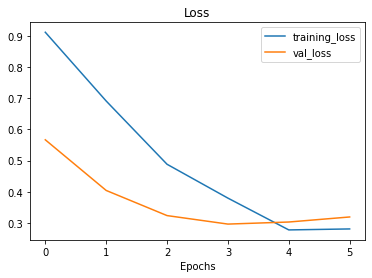

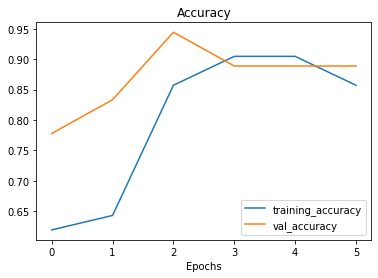

In [19]:
plot_loss_curves(history_0)

# Model 1: FT(Resnet50) -> Functional API ->Augmentation

In [21]:
# Set Checkpoint paths
checkpoint_path_1 = 'Checkpoints_weights/Resnet50_Augmented_FT_checkpoints.ckpt'

# Create a ModelCheckpoint callback that saves the model's weights only
checkpoint_callback_1 = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path_1,
                                                         save_weights_only=True,
                                                         save_best_only=False,
                                                         save_freq='epoch', # save ever epoch
                                                         verbose=1)

In [24]:
# To begin fine-tuning,let's start by setting the last 10 layers of our base_model.trainable = True
base_model.trainable = True

# Freeze all layers except for the last 10
for layer in base_model.layers[:-20]:
  layer.trainable = False

# Recompile (Since we made a change)
model_0.compile(
    loss=tf.keras.losses.CategoricalCrossentropy(), # Not Sparse since we are using data from a special function
    optimizer = tf.keras.optimizers.Adam(lr=0.0001),# When fine-tuning, typically we lower the lr by 10x*
    metrics = ['accuracy']
)

/usr/local/lib/python3.8/dist-packages/keras/optimizers/optimizer_v2/adam.py:110: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


In [25]:
#Fit the model
fine_tune_epochs = initial_epochs+10

history_0_ft = model_0.fit(train_data_2,
                        epochs=initial_epochs,
                        validation_data=test_data_2,
                        validation_steps = len(test_data_2),
                        initial_epoch=history_0.epoch[-1],
                        callbacks = [
                                    early_stopping_callback,
                                    #  checkpoint_callback_3, # because it slows down
                                     create_tensorboard_callback(dir_name='CV_Question1', experiment_name='model_4')]
                        )

Saving TensorBoard log files to: CV_Question1/model_4/20230227-064306
Epoch 6/20
2/2 [==============================] - 24s 10s/step - loss: 0.3184 - accuracy: 0.8571 - val_loss: 1.1577 - val_accuracy: 0.7222
Epoch 7/20
2/2 [==============================] - 16s 5s/step - loss: 0.4504 - accuracy: 0.8095 - val_loss: 0.0886 - val_accuracy: 0.9444
Epoch 8/20
2/2 [==============================] - 17s 8s/step - loss: 0.1808 - accuracy: 0.9286 - val_loss: 0.7101 - val_accuracy: 0.7222
Epoch 9/20
2/2 [==============================] - 19s 9s/step - loss: 0.2723 - accuracy: 0.9048 - val_loss: 0.2124 - val_accuracy: 0.9444
Epoch 10/20
2/2 [==============================] - 12s 6s/step - loss: 0.1019 - accuracy: 0.9762 - val_loss: 0.0769 - val_accuracy: 0.9444


## Evaluate

In [26]:
model_0.evaluate(test_data_2)

1/1 [==============================] - 4s 4s/step - loss: 0.0886 - accuracy: 0.9444


[0.08856935054063797, 0.9444444179534912]

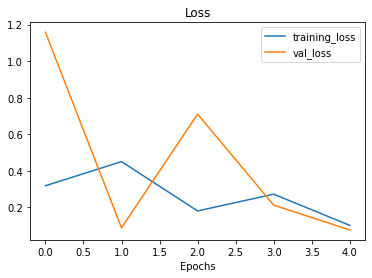

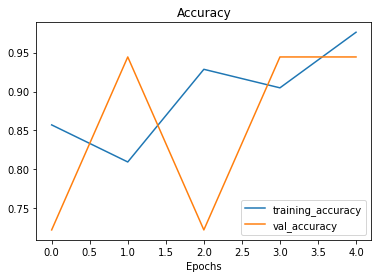

In [27]:
plot_loss_curves(history_0_ft)

# 6 . Save the best Model

In [28]:
model_0.save('model_0_FT.h5')

# 7 . Load from the saved Model

In [29]:
loaded_model = tf.keras.models.load_model("model_0_FT.h5")

In [30]:
loaded_model.evaluate(test_data_2)

1/1 [==============================] - 6s 6s/step - loss: 0.0886 - accuracy: 0.9444


[0.08856934309005737, 0.9444444179534912]

# 8 . Predict

## Load Image

In [32]:
import cv2
img = cv2.imread('darthVader.jpeg')
img = cv2.resize(img,(224,224))     # resize image to match model's expected sizing
img = img.reshape(1,224,224,3)

In [33]:
loaded_model.predict(img).argmax()

1/1 [==============================] - 1s 1s/step


0

In [34]:
class_names[0]

'Darth Vader'